In [1]:
# !pip install wheel
# !pip install h5py
# !pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import h5py
import yaml
import pickle
import os
import argparse
import random
from tqdm.notebook import tqdm
from collections import Counter
from dataclasses import dataclass, field
import contextlib

In [3]:
data = pd.read_csv('../processed_data/utrs.csv')
data = data[['Gene Name', 'foreign']].dropna(axis=0).rename(columns={'Gene Name': 'gene', 'foreign':'seq'})

In [4]:
data.head()

,gene,seq
4,VPS8,ACATTTCTAAATATTTAATACAACTTTGGTTACATAAAAGTAAAAT...
5,SSA1,AGCCAATTGGTGCGGCAATTGATAATAACGAAAATGTCTTTTAATG...
6,ERP2,AGAACTTTTCAATCTACGAAAAATATATGTCCGCAATATAGAACAC...
7,FUN14,AGCAAGACAAATGACCAGATATAAACGAGGGTTATATTCTTTCGTT...
8,SPO7,AAAGAGTTGGAGGGCTTCTTCCTTCGAATAAGAGGTCATATTTACC...


In [5]:
#k-mers
seqk = 5
stride = seqk // 2
data['kmers'] = data['seq'].apply(lambda x: [x[c:c+seqk] for c in np.arange(0, len(x) ,stride)]).apply(lambda x: [y for y in x if len(y)==seqk])


In [6]:
corpus = [y  for x in data['kmers'] for y in x]

In [157]:
%%writefile gloveConfig.yaml
# first step parameters
## path to the input file, should be a pickle file storing a list of words
input_filepath:
## number of tokens in the training vocabulary
vocab_size: 1024 # 4^5
## size of the context window
window_size: 10
## the number of paritions to divide cooccurence matrix in 
num_partitions: 10
## chunk size of h5py.Dataset
chunk_size: 1000000

# when used in first step, specify the output directory of cooccurrence entries
# when used in second step, specify where to read cooccurrence entries from
cooccurrence_dir: ../processed_data/utrs/cooccurence

# second step parameters
## output path for the trained word vectors 
output_filepath: ../model/utrs/gloveModel
## pytorch training parameters
batch_size: 32
num_epochs: 100
device: cuda
learning_rate: 0.1
## glove paremeters
embedding_size: 50
x_max: 100
alpha: 0.75

Overwriting gloveConfig.yaml


In [8]:
def load_config():
    config_filepath = "gloveConfig.yaml"
    with open(config_filepath, 'r') as f:
        config_dict = yaml.load(f, Loader=yaml.FullLoader)
    config = argparse.Namespace()
    for key, value in config_dict.items():
        setattr(config, key, value)
    return config

In [9]:

@dataclass
class Vocabulary:
    token2index: dict = field(default_factory=dict)
    index2token: dict = field(default_factory=dict)
    token_counts: list = field(default_factory=list)
    _unk_token: int = field(init=False, default=-1)
    
    def add(self, token):
        if token not in self.token2index:
            index = len(self)
            self.token2index[token] = index
            self.index2token[index] = token
            self.token_counts.append(0)
        self.token_counts[self.token2index[token]] += 1
    
    def get_topk_subset(self, k):
        tokens = sorted(
            list(self.token2index.keys()),
            key=lambda token: self.token_counts[self[token]],
            reverse=True
        )
        return type(self)(
            token2index={token: index for index, token in enumerate(tokens[:k])},
            index2token={index: token for index, token in enumerate(tokens[:k])},
            token_counts=[
                self.token_counts[self.token2index[token]] for token in tokens[:k]
            ]
        )
    
    def shuffle(self):
        new_index = [_ for _ in range(len(self))]
        random.shuffle(new_index)
        new_token_counts = [None] * len(self)
        for token, index in zip(list(self.token2index.keys()), new_index):
            new_token_counts[index] = self.token_counts[self[token]]
            self.token2index[token] = index
            self.index2token[index] = token
        self.token_counts = new_token_counts

    def get_index(self, token):
        return self[token]
    
    def get_token(self, index):
        if not index in self.index2token:
            raise Exception("Invalid index.")
        return self.index2token[index]
    
    @property
    def unk_token(self):
        return self._unk_token
    
    def __getitem__(self, token):
        if token not in self.token2index:
            return self._unk_token
        return self.token2index[token]
    
    def __len__(self):
        return len(self.token2index)

In [10]:
@dataclass
class Vectorizer:
    vocab: Vocabulary

    @classmethod
    def from_corpus(cls, corpus, vocab_size):
        vocab = Vocabulary()
        for token in corpus:
            vocab.add(token)
        vocab_subset = vocab.get_topk_subset(vocab_size)
        vocab_subset.shuffle()
        return cls(vocab_subset)

    def vectorize(self, corpus):
        return [self.vocab[token] for token in corpus]

In [11]:
@dataclass
class CooccurrenceEntries:
    vectorized_corpus: list
    vectorizer: Vectorizer
    
    @classmethod
    def setup(cls, corpus, vectorizer):
        return cls(
            vectorized_corpus=vectorizer.vectorize(corpus),
            vectorizer=vectorizer
        )
    
    def validate_index(self, index, lower, upper):
        is_unk = index == self.vectorizer.vocab.unk_token
        if lower < 0:
            return not is_unk
        return not is_unk and index >= lower and index <= upper

    def build(
        self,
        window_size,
        num_partitions,
        chunk_size,
        output_directory="."
    ):
        partition_step = len(self.vectorizer.vocab) // num_partitions
        split_points = [0]
        while split_points[-1] + partition_step <= len(self.vectorizer.vocab):
            split_points.append(split_points[-1] + partition_step)
        split_points[-1] = len(self.vectorizer.vocab)

        for partition_id in tqdm(range(len(split_points) - 1)):
            index_lower = split_points[partition_id]
            index_upper = split_points[partition_id + 1] - 1
            cooccurr_counts = Counter()
            for i in tqdm(range(len(self.vectorized_corpus))):
                if not self.validate_index(
                    self.vectorized_corpus[i],
                    index_lower,
                    index_upper
                ):
                    continue
                
                context_lower = max(i - window_size, 0)
                context_upper = min(i + window_size + 1, len(self.vectorized_corpus))
                for j in range(context_lower, context_upper):
                    if i == j or not self.validate_index(
                        self.vectorized_corpus[j],
                        -1,
                        -1
                    ):
                        continue
                    cooccurr_counts[(self.vectorized_corpus[i], self.vectorized_corpus[j])] += 1 / abs(i - j)

            cooccurr_dataset = np.zeros((len(cooccurr_counts), 3))
            for index, ((i, j), cooccurr_count) in enumerate(cooccurr_counts.items()):
                cooccurr_dataset[index] = (i, j, cooccurr_count)
            if partition_id == 0:
                os.makedirs(output_directory, exist_ok=True)
                file = h5py.File(
                    os.path.join(
                        output_directory,
                        "cooccurrence.hdf5"
                    ),
                    "w"
                )
                dataset = file.create_dataset(
                    "cooccurrence",
                    (len(cooccurr_counts), 3),
                    maxshape=(None, 3),
                    chunks=(chunk_size, 3)
                )
                prev_len = 0
            else:
                prev_len = dataset.len()
                dataset.resize(dataset.len() + len(cooccurr_counts), axis=0)
            dataset[prev_len: dataset.len()] = cooccurr_dataset
        
        file.close()
        with open(os.path.join(output_directory, "vocab.pkl"), "wb") as file:
            pickle.dump(self.vectorizer.vocab, file)

In [12]:
config = load_config()
vectorizer = Vectorizer.from_corpus(
    corpus=corpus,
    vocab_size=config.vocab_size
)
cooccurrence = CooccurrenceEntries.setup(
    corpus=corpus,
    vectorizer=vectorizer
)
cooccurrence.build(
    window_size=config.window_size,
    num_partitions=config.num_partitions,
    chunk_size=config.chunk_size,
    output_directory=config.cooccurrence_dir
) 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/626994 [00:00<?, ?it/s]

  0%|          | 0/626994 [00:00<?, ?it/s]

  0%|          | 0/626994 [00:00<?, ?it/s]

  0%|          | 0/626994 [00:00<?, ?it/s]

  0%|          | 0/626994 [00:00<?, ?it/s]

  0%|          | 0/626994 [00:00<?, ?it/s]

  0%|          | 0/626994 [00:00<?, ?it/s]

  0%|          | 0/626994 [00:00<?, ?it/s]

  0%|          | 0/626994 [00:00<?, ?it/s]

  0%|          | 0/626994 [00:00<?, ?it/s]

In [13]:
@dataclass
class CooccurrenceDataset(torch.utils.data.Dataset):
    token_ids: torch.Tensor
    cooccurr_counts: torch.Tensor

    def __getitem__(self, index):
        return [self.token_ids[index], self.cooccurr_counts[index]]
    
    def __len__(self):
        return self.token_ids.size()[0]

    
@dataclass
class HDF5DataLoader:
    filepath: str
    dataset_name: str
    batch_size: int
    device: str
    dataset: h5py.Dataset = field(init=False)

    def iter_batches(self):
        chunks = list(self.dataset.iter_chunks())
        random.shuffle(chunks)
        for chunk in chunks:
            chunked_dataset = self.dataset[chunk]
            dataloader = torch.utils.data.DataLoader(
                dataset=CooccurrenceDataset(
                    token_ids=torch.from_numpy(chunked_dataset[:,:2]).long(),
                    cooccurr_counts=torch.from_numpy(chunked_dataset[:,
                        2]).float()
                ),
                batch_size=self.batch_size,
                shuffle=True,
                pin_memory=True
            )
            for batch in dataloader:
                batch = [_.to(self.device) for _ in batch]
                yield batch

    @contextlib.contextmanager
    def open(self):
        with h5py.File(self.filepath, "r") as file:
            self.dataset = file[self.dataset_name]
            yield

In [14]:
class GloVe(nn.Module):

    def __init__(self, vocab_size, embedding_size, x_max, alpha):
        super().__init__()
        self.weight = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_size,
            sparse=True
        )
        self.weight_tilde = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_size,
            sparse=True
        )
        self.bias = nn.Parameter(
            torch.randn(
                vocab_size,
                dtype=torch.float,
            )
        )
        self.bias_tilde = nn.Parameter(
            torch.randn(
                vocab_size,
                dtype=torch.float,
            )
        )
        self.weighting_func = lambda x: (x / x_max).float_power(alpha).clamp(0, 1)
    
    def forward(self, i, j, x):
        loss = torch.mul(self.weight(i), self.weight_tilde(j)).sum(dim=1)
        loss = (loss + self.bias[i] + self.bias_tilde[j] - x.log()).square()
        loss = torch.mul(self.weighting_func(x), loss).mean()
        return loss

In [15]:
config = load_config()
dataloader = HDF5DataLoader(
    filepath=os.path.join(config.cooccurrence_dir, "cooccurrence.hdf5"),
    dataset_name="cooccurrence",
    batch_size=config.batch_size,
    device=config.device
)
model = GloVe(
    vocab_size=config.vocab_size,
    embedding_size=config.embedding_size,
    x_max=config.x_max,
    alpha=config.alpha
)
model.to(config.device)
optimizer = torch.optim.Adagrad(
    model.parameters(),
    lr=config.learning_rate
)
losses = []


with dataloader.open():
    model.train()
    
    for epoch in tqdm(range(config.num_epochs)):
        epoch_loss = 0
        for batch in tqdm(dataloader.iter_batches()):
            loss = model(
                batch[0][:, 0],
                batch[0][:, 1],
                batch[1]
            )
            epoch_loss += loss.detach().item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        losses.append(epoch_loss)
        print(f"Epoch {epoch}: loss = {epoch_loss}")
        os.makedirs(os.sep.join(config.output_filepath.split(os.sep)[:-1]),exist_ok=True)
        torch.save(model.state_dict(), config.output_filepath)

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 0: loss = 39614.31807328563


0it [00:00, ?it/s]

Epoch 1: loss = 13122.144350364797


0it [00:00, ?it/s]

Epoch 2: loss = 8155.94826474233


0it [00:00, ?it/s]

Epoch 3: loss = 5945.059387218604


0it [00:00, ?it/s]

Epoch 4: loss = 4729.475707149072


0it [00:00, ?it/s]

Epoch 5: loss = 3974.357875614273


0it [00:00, ?it/s]

Epoch 6: loss = 3463.128848078453


0it [00:00, ?it/s]

Epoch 7: loss = 3094.4852765259034


0it [00:00, ?it/s]

Epoch 8: loss = 2815.1727937367577


0it [00:00, ?it/s]

Epoch 9: loss = 2595.343834100928


0it [00:00, ?it/s]

Epoch 10: loss = 2416.6394192224507


0it [00:00, ?it/s]

Epoch 11: loss = 2267.959160513965


0it [00:00, ?it/s]

Epoch 12: loss = 2141.573583748782


0it [00:00, ?it/s]

Epoch 13: loss = 2032.7688856460982


0it [00:00, ?it/s]

Epoch 14: loss = 1937.7691440824558


0it [00:00, ?it/s]

Epoch 15: loss = 1854.0297565616943


0it [00:00, ?it/s]

Epoch 16: loss = 1779.717361163844


0it [00:00, ?it/s]

Epoch 17: loss = 1713.1885782205954


0it [00:00, ?it/s]

Epoch 18: loss = 1653.4120143426342


0it [00:00, ?it/s]

Epoch 19: loss = 1599.5136461476031


0it [00:00, ?it/s]

Epoch 20: loss = 1550.578883064366


0it [00:00, ?it/s]

Epoch 21: loss = 1506.0355098113394


0it [00:00, ?it/s]

Epoch 22: loss = 1465.3893005044733


0it [00:00, ?it/s]

Epoch 23: loss = 1428.2376670989208


0it [00:00, ?it/s]

Epoch 24: loss = 1394.1195122877552


0it [00:00, ?it/s]

Epoch 25: loss = 1362.680795200091


0it [00:00, ?it/s]

Epoch 26: loss = 1333.6405460298322


0it [00:00, ?it/s]

Epoch 27: loss = 1306.880811416203


0it [00:00, ?it/s]

Epoch 28: loss = 1281.9625865750995


0it [00:00, ?it/s]

Epoch 29: loss = 1258.7689535457007


0it [00:00, ?it/s]

Epoch 30: loss = 1237.2240353441011


0it [00:00, ?it/s]

Epoch 31: loss = 1217.0970760637404


0it [00:00, ?it/s]

Epoch 32: loss = 1198.2725650947784


0it [00:00, ?it/s]

Epoch 33: loss = 1180.6243595233486


0it [00:00, ?it/s]

Epoch 34: loss = 1164.0238516431139


0it [00:00, ?it/s]

Epoch 35: loss = 1148.4381325989746


0it [00:00, ?it/s]

Epoch 36: loss = 1133.7551829071633


0it [00:00, ?it/s]

Epoch 37: loss = 1119.8456337265263


0it [00:00, ?it/s]

Epoch 38: loss = 1106.73565558296


0it [00:00, ?it/s]

Epoch 39: loss = 1094.3109388438852


0it [00:00, ?it/s]

Epoch 40: loss = 1082.519219384839


0it [00:00, ?it/s]

Epoch 41: loss = 1071.3041400577579


0it [00:00, ?it/s]

Epoch 42: loss = 1060.6441716835116


0it [00:00, ?it/s]

Epoch 43: loss = 1050.4915669121353


0it [00:00, ?it/s]

Epoch 44: loss = 1040.8287266207624


0it [00:00, ?it/s]

Epoch 45: loss = 1031.5922620626689


0it [00:00, ?it/s]

Epoch 46: loss = 1022.7256513895958


0it [00:00, ?it/s]

Epoch 47: loss = 1014.2623817060863


0it [00:00, ?it/s]

Epoch 48: loss = 1006.1785682385033


0it [00:00, ?it/s]

Epoch 49: loss = 998.384801940546


0it [00:00, ?it/s]

Epoch 50: loss = 990.9181688209582


0it [00:00, ?it/s]

Epoch 51: loss = 983.7733869992148


0it [00:00, ?it/s]

Epoch 52: loss = 976.8598075323249


0it [00:00, ?it/s]

Epoch 53: loss = 970.2082481999443


0it [00:00, ?it/s]

Epoch 54: loss = 963.7964709205818


0it [00:00, ?it/s]

Epoch 55: loss = 957.639997000469


0it [00:00, ?it/s]

Epoch 56: loss = 951.673132403422


0it [00:00, ?it/s]

Epoch 57: loss = 945.9161825317506


0it [00:00, ?it/s]

Epoch 58: loss = 940.3641212868358


0it [00:00, ?it/s]

Epoch 59: loss = 934.9624772050717


0it [00:00, ?it/s]

Epoch 60: loss = 929.7695554461268


0it [00:00, ?it/s]

Epoch 61: loss = 924.7393688562506


0it [00:00, ?it/s]

Epoch 62: loss = 919.8446119345373


0it [00:00, ?it/s]

Epoch 63: loss = 915.0985979755503


0it [00:00, ?it/s]

Epoch 64: loss = 910.4871448520018


0it [00:00, ?it/s]

Epoch 65: loss = 906.006268560985


0it [00:00, ?it/s]

Epoch 66: loss = 901.678085745096


0it [00:00, ?it/s]

Epoch 67: loss = 897.4588654834516


0it [00:00, ?it/s]

Epoch 68: loss = 893.338925859502


0it [00:00, ?it/s]

Epoch 69: loss = 889.358352213393


0it [00:00, ?it/s]

Epoch 70: loss = 885.4604627777171


0it [00:00, ?it/s]

Epoch 71: loss = 881.6695942137676


0it [00:00, ?it/s]

Epoch 72: loss = 877.9838796053514


0it [00:00, ?it/s]

Epoch 73: loss = 874.3950127906372


0it [00:00, ?it/s]

Epoch 74: loss = 870.8673121863847


0it [00:00, ?it/s]

Epoch 75: loss = 867.4443182781555


0it [00:00, ?it/s]

Epoch 76: loss = 864.0809296970996


0it [00:00, ?it/s]

Epoch 77: loss = 860.849919391983


0it [00:00, ?it/s]

Epoch 78: loss = 857.6495070644821


0it [00:00, ?it/s]

Epoch 79: loss = 854.5216246341793


0it [00:00, ?it/s]

Epoch 80: loss = 851.4714327934489


0it [00:00, ?it/s]

Epoch 81: loss = 848.4912274389395


0it [00:00, ?it/s]

Epoch 82: loss = 845.5706367351922


0it [00:00, ?it/s]

Epoch 83: loss = 842.7110244247667


0it [00:00, ?it/s]

Epoch 84: loss = 839.9280450148685


0it [00:00, ?it/s]

Epoch 85: loss = 837.1878934561748


0it [00:00, ?it/s]

Epoch 86: loss = 834.4981414946594


0it [00:00, ?it/s]

Epoch 87: loss = 831.8596288282948


0it [00:00, ?it/s]

Epoch 88: loss = 829.2977194645306


0it [00:00, ?it/s]

Epoch 89: loss = 826.7836077261197


0it [00:00, ?it/s]

Epoch 90: loss = 824.2936544685866


0it [00:00, ?it/s]

Epoch 91: loss = 821.8561794598879


0it [00:00, ?it/s]

Epoch 92: loss = 819.4828295110404


0it [00:00, ?it/s]

Epoch 93: loss = 817.1318493638774


0it [00:00, ?it/s]

Epoch 94: loss = 814.8336386457099


0it [00:00, ?it/s]

Epoch 95: loss = 812.5826706051887


0it [00:00, ?it/s]

Epoch 96: loss = 810.3719395208627


0it [00:00, ?it/s]

Epoch 97: loss = 808.1805281992547


0it [00:00, ?it/s]

Epoch 98: loss = 806.0520707315835


0it [00:00, ?it/s]

Epoch 99: loss = 803.9418062394307


In [93]:
vectors = (model.weight.weight.to('cpu').detach() + model.weight_tilde.weight.to('cpu').detach()).numpy()

In [94]:
vectors.shape

(1024, 50)

In [99]:
data['kmers_vec'] = [vectorizer.vectorize(x) for x in data['kmers']]

In [100]:
data['kmers_enc'] = [np.mean(vectors[x, :], axis=0) for x in data['kmers_vec']]

In [101]:
gloveUtrs = np.vstack(data['kmers_enc'])

In [102]:
gloveUtrs.shape

(4870, 50)

In [103]:
np.isfinite(gloveUtrs).all()

False

In [104]:
fDf = pd.read_csv('../processed_data/fluorescence_dataset.csv')
fDf.dropna(subset=['intensity'],inplace=True)
fDf.head()

,gene,systematicName,intensity
0,SSA1,YAL005C,11.906396
1,ERP2,YAL007C,0.299776
2,FUN14,YAL008W,0.455914
3,SPO7,YAL009W,0.027090
5,SWC3,YAL011W,0.031941


In [105]:
whole = data[['gene', 'kmers_enc']].merge(fDf[['gene','intensity']], on='gene', how='inner')
whole.head()

,gene,kmers_enc,intensity
0,SSA1,"[0.059176162, 0.030547542, 0.21283105, -0.1606...",11.906396
1,ERP2,"[-0.0878673, -0.04181469, 0.126148, -0.1353118...",0.299776
2,FUN14,"[-0.07698463, -0.13328509, 0.33653557, -0.3655...",0.455914
3,SPO7,"[0.033837233, -0.10858796, 0.1346016, -0.19186...",0.027090
4,SWC3,"[-0.089029185, -0.11479269, 0.10291183, 0.0359...",0.031941


In [142]:
i = whole['intensity']
i[i<=0] = 0.0001 # negative intensities make no sense
y = np.log(i)
x = np.vstack(whole['kmers_enc'])

/tmp/ipykernel_84344/2599492880.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i[i<=0] = 0.0001 # negative intensities make no sense


In [143]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pcs = PCA(2).fit_transform(StandardScaler().fit_transform(x))

In [144]:
from matplotlib import pyplot as plt

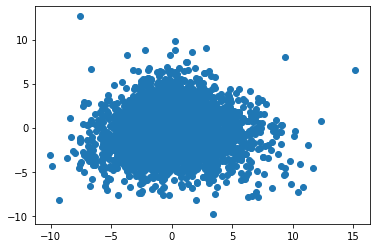

In [145]:
plt.scatter(pcs[:, 0], pcs[:, 1])

No linear discriminant property found, trying to overfit a RandomFores

In [146]:
from sklearn.ensemble import RandomForestRegressor

In [147]:
preds = RandomForestRegressor().fit(x,y).predict(x)

In [170]:
np.sum((preds - y)**2)

3730.3748657097995

In [151]:
np.sum((y)**2)

59526.857087858465

In [159]:
from sklearn.metrics.pairwise import cosine_similarity
xcos = cosine_similarity(x, x)

In [160]:
xcos.shape

(3752, 3752)

In [165]:
xcos.max()

1.0000004

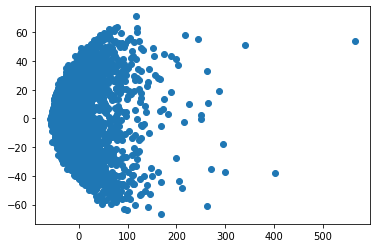

In [167]:
from sklearn.decomposition import PCA
pcs = PCA(200).fit_transform(RobustScaler().fit_transform(xcos))
plt.scatter(pcs[:, 0], pcs[:, 1])

In [168]:
cos_preds = RandomForestRegressor().fit(pcs,y).predict(pcs)

In [169]:
np.sum((cos_preds - y)**2)

4150.401743024404

In [194]:
from sklearn import tree
treeRegressor = tree.DecisionTreeRegressor(max_leaf_nodes=200, criterion='friedman_mse')
tree_preds = treeRegressor.fit(x, y).predict(x)
np.sum((tree_preds - y)**2)

8646.293391998455

In [174]:
import graphviz 
dot_data = tree.export_graphviz(treeRegressor, filled=True, out_file=None) 
graph = graphviz.Source(dot_data)
graph.render("gloveUtrsTree") 

'gloveUtrsTree.pdf'

In [158]:
import pickle
with open('../processed_data/utrs_glove_embeddings.pkl', 'wb') as out:
    pickle.dump({'data':np.vstack(data['kmers_enc']),'genes':data['gene']}, out)